# <font color='gren'> Exercício 4


In [383]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.linalg import solve 
import math

## 1 - Funções auxiliares com modificações para o círculo central


* Pré-setagem

In [384]:
N=41
tol=10**(-5)

* Função para plotar os curvas de nível constante de temperatura

In [385]:
# Função para plotar os curvas de nível constante de temperatura
def PlotaTemperature(n,m,T):
    x = np.arange(0, n, 1)
    y = np.arange(0, m, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(T)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of temperature')
    im = ax.contourf(X, Y, Z.T, 20, cmap='jet')
    im2 = ax.contour(X, Y, Z.T, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()

* Função que adiciona temperatura a um círculo central a placa com um dado raio (que vai de 0.0 a 1.0 da largura da placa) -> sendo necessário in

In [386]:
def temp_circ(N,T,TC,R): #Para os métodos iterativos não gerais
    if(0<=R and R<=1):
        for i in range(0,N):
            for j in range(0,N):
                if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 < (R*(N-1))**2 ): #Faz a verificação se está dentro
                    T[i][j]=TC

# Função para converter indice (i,j) a indice global Ic
def ij2n (i, j, N):
    return (i + j*N)

def geral_temp_circ(N,Atilde,b,TC,R): #Para os métodos iterativos gerais sem preservação de simetria
    if(0<=R and R<=1):
        for i in range(0,N):
            for j in range(0,N):
                if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 < (R*(N-1))**2 ): #Faz a verificação se está dentro
                    Ic=ij2n(i,j,N)
                    Atilde[Ic , :]=0
                    Atilde[Ic][Ic]=1
                    b[Ic]=TC
                

def simgeral_temp_circ(N,Atilde,A,b,TC,R): #Para os métodos iterativos gerais com preservação de simetria
    if(0<=R and R<=1):
        for i in range(0,N):
            for j in range(0,N):
                if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 < (R*(N-1))**2 ): #Faz a verificação se está dentro
                    Ic=ij2n(i,j,N)
                    for k in range(0,N**2):
                        b[k]=b[k]-A[k][Ic]
                    b[Ic]=TC
                    Atilde[Ic][:]=0
                    Atilde[:][Ic]=0
                    Atilde[Ic][Ic]=1
       
        
                    
            

* Método de Gauss-Seidel: modificada para retornar número de interações

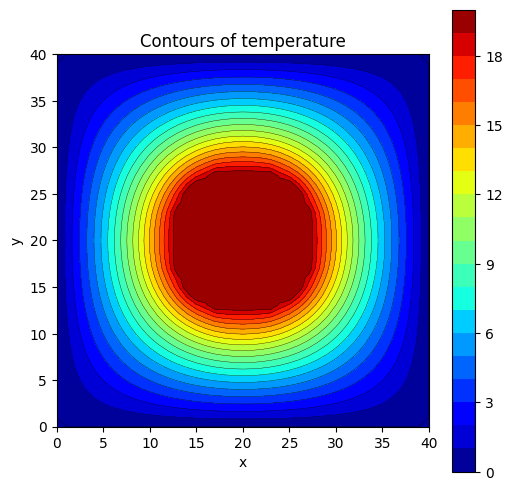

In [387]:
def metod_gauss_seidel(N,TL,TR,TB,TT,TC,R,Nmax,tol):

    Told = np.zeros(shape=(N,N))

    # Temperaturas nas bordas
    Told[0,  :] = TL
    Told[N-1,:] = TR
    Told[:,  0] = TB
    Told[:,N-1] = TT

    #Temperatura no círculo central
    temp_circ(N,Told,TC,R)

    # Loop de iteracoes
    Tnew = Told.copy()
    for iter in range(Nmax):
        for i in range(1,N-1):
            for j in range(1,N-1):
                if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 >= (R*(N-1))**2 ):
                    Tnew[i,j] = 0.25*(Told[i+1,j] + Tnew[i-1,j] +\
                                    Told[i,j+1] + Tnew[i,j-1])
        
        error = np.linalg.norm(Tnew-Told)
        #print(iter, '  ', error)
        if(error < tol):
            return Tnew
            
        Told = Tnew.copy()

PlotaTemperature(N,N,metod_gauss_seidel(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2, 10000, tol))

* Métodos de montagem explícita da matriz A

In [388]:

# Função para montar a matriz do sistema
def MatAssembly(N,R):
    nunk = N**2
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1):
            if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 >= (R*(N-1))**2 ):
                Ic = ij2n(i,   j,   N)
                Ie = ij2n(i+1, j,   N)
                Iw = ij2n(i-1, j,   N)
                In = ij2n(i,   j+1, N)
                Is = ij2n(i,   j-1, N)
                k=np.array([Ic,Ie,Iw,In,Is])
                A[Ic,k] =[4.0, -1.0, -1.0, -1.0, -1.0]
    return A

* Função que coloca temperaturas de borda e monta o sistema

20.784609690826528


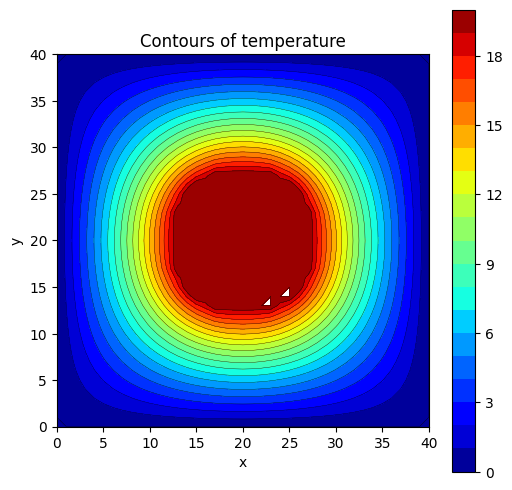

In [389]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystem(N, TL, TR, TB, TT, TC, R):
    nunk = N**2
    A = MatAssembly(N,R)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk,1))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    geral_temp_circ(N,Atilde,b,TC,R)

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT # Ttop
    
    return Atilde, b

Atilde, b = BuildSystem(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2)
print(np.linalg.norm(Atilde-Atilde.T))

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)


* Condições de borda mantendo a simetria

*Observação: para cada Ic[r] o elemento aij correspondete a uma terperatura de borda na matriz b passará 
para o outro lado subtraindo aij x Tj*

10.954451150103322


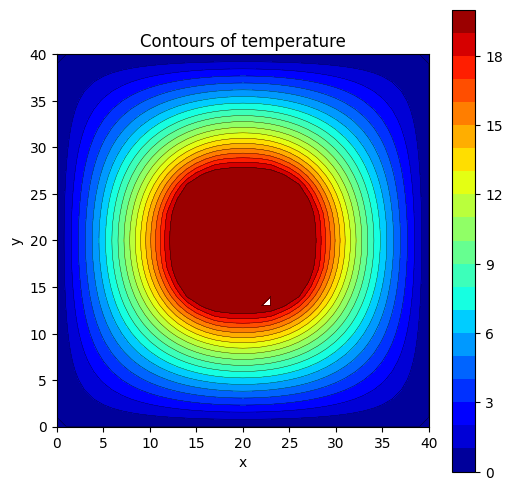

In [390]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemSim(N, TL, TR, TB, TT, TC, R):
    nunk = N**2
    A = MatAssembly(N,R)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    simgeral_temp_circ(N,Atilde,A,b,TC,R)

    Ic = ij2n(0,k,N) # Tleft
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TL 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(N-1,k,N) # Tright
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TR
    #somente os termos b[Ic[k]] com k variando de 0 a N-1, correspondentes a uma borda,
    #tem a temperatura dessa respectiva borda
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR
    Atilde[:,Ic] = Iden[:,Ic]
    
    Ic = ij2n(k,0,N) # Tbottom
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TB 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) # Ttop
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TT
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT
    Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b



Atilde, b = BuildSystemSim(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2)
print(np.linalg.norm(Atilde-Atilde.T))

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

## 2 - Método Iterativo

1212 passos


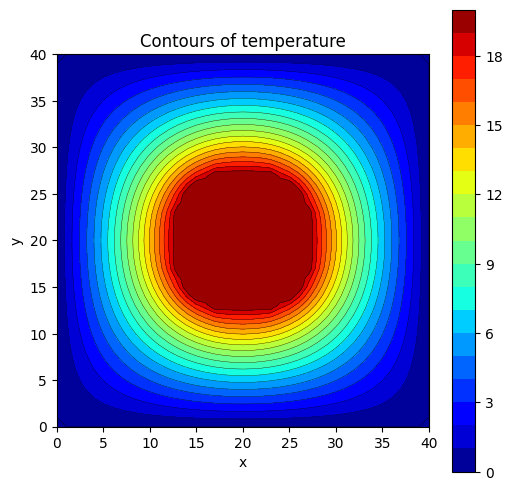

In [391]:
def iterativ_metod_1(N, TL, TR, TB, TT, TC, R, Nmax, tol):
    A,b=BuildSystem(N, TL, TR, TB, TT, TC, R)
    M=np.zeros(shape=(N**2,N**2))
    for i in range(0,N**2):
        M[i][i]=A[i][i]
    cold=b.copy() #primeiro chute para x é um vetor b
    cnew=b.copy()    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return cnew, k #retorma resultado e número de passos
T,k=iterativ_metod_1(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2, 10000, tol)
print(k,'passos')
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

608 passos


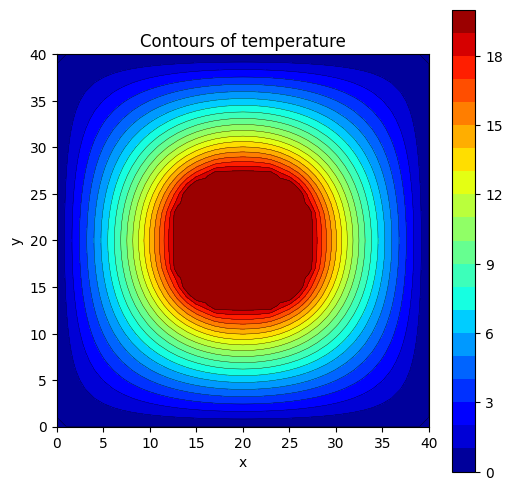

In [392]:
def iterativ_metod_2(N, TL, TR, TB, TT, TC, R, Nmax, tol):
    A,b=BuildSystem(N, TL, TR, TB, TT, TC, R)
    M=np.triu(A)
    cold=b.copy()*0 #primeiro chute para x é um vetor b
    cnew=b.copy()*0    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return cnew,k #retorma resultado e número
T,k=iterativ_metod_2(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2, 10000, tol)
print(k,'passos')
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)


1216 passos


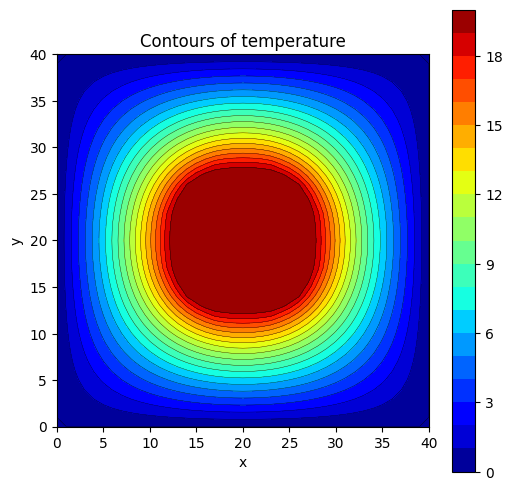

In [393]:
def iterativ_simetricmetod_1(N, TL, TR, TB, TT, TC, R, Nmax, tol):
    A,b=BuildSystemSim(N, TL, TR, TB, TT, TC, R)
    M=np.zeros(shape=(N**2,N**2))
    for i in range(0,N**2):
        M[i][i]=A[i][i]
    cold=b.copy() #primeiro chute para x é um vetor b
    cnew=b.copy()    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=scipy.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return cnew,k #retorna resultado e número de passos
T,k=iterativ_simetricmetod_1(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2, 10000,tol)
print(k,'passos')
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

611 passos


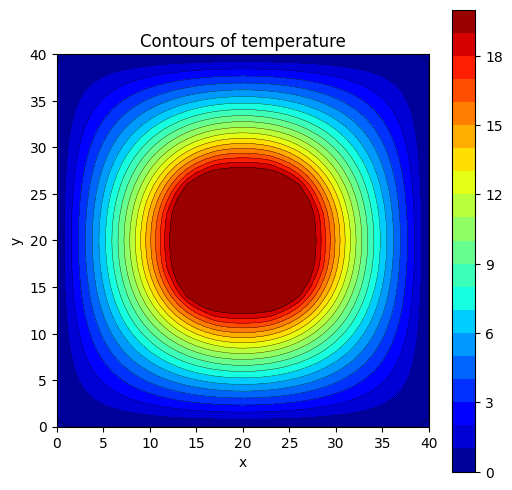

In [394]:
def iterativ_simetricmetod_2(N, TL, TR, TB, TT, TC, R, Nmax, tol):
    A,b=BuildSystemSim(N, TL, TR, TB, TT, TC, R)
    M=np.triu(A)
    cold=b.copy()*0 #primeiro chute para x é um vetor b
    cnew=b.copy()*0    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=scipy.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    
    return cnew,k #retorna resultado e número de passos
T,k=iterativ_simetricmetod_2(N, 0.0, 0.0, 0.0, 0.0, 20.0, 0.2, 10000, tol)
print(k,'passos')
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)